# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output='pandas')

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

tf.config.experimental.enable_op_determinism()

# Data
- Making a mulit-class text classification to match each passage to the correct author.
- ['Spooky'](https://drive.google.com/file/d/1uUtuiAM1AqGvDMrd3-L8vLFfHPrt3pWG/view?usp=sharing) dataset.
    - Passages from three famaous authors:
        - Edgar Allan Poe
        - HP Lovecraft
        - Mary Shelley

In [2]:
# Loading data from data folder
df = pd.read_csv('Data/spooky.csv', index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, id26305 to id00393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19579 non-null  object
 1   author  19579 non-null  object
dtypes: object(2)
memory usage: 458.9+ KB


- Want to look at the length of each text
- Using lambda function to split on space and get the length
- Using .describe to get statics on length

In [3]:
# Making new column to hold text length
df['sequence_length'] = df['text'].map(lambda x: len(x.split(' ')))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [4]:
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

- Mean length = 26.7
- Range length = 2-861

# RandomUnderSampler

In [5]:
df['author'].value_counts(dropna=False)

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [6]:
# Resampling dataframe and not X,y
sampler = RandomUnderSampler()
df,_=sampler.fit_resample(df,df['author'])
df['author'].value_counts(dropna=False)

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

# X, y
- Using .map to change 'author' column to numerical data and defineing it as y(target)

In [7]:
# Creat a map for targets
target_map = {'EAP':0, 'HPL':1, 'MWS':2}

# Define y as target
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

In [8]:
# X
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [9]:
classes = y.unique()
classes

array([0, 1, 2])

# Convert to dataset object using Dataset.from_tensor_slices()
- Shuffle the data

In [10]:
# convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X,y))

# Shuffle dataset
ds = ds.shuffle(buffer_size = len(ds), reshuffle_each_iteration=False)

Metal device set to: Apple M1


# TTS
- train size = .7
- val size = .2
- test size = 1 - (train + val)
- Use batch size 31

In [11]:
# Set the ratio of train, val, and test split
split_train = .7
split_val = .2
split_test = 1 - (split_train + split_val)

# Calculate the number of samples for training, val and test data
n_train_samples = int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -  (n_train_samples + n_val_samples)

# Set Batch size
b_size = 32

import math 
# math.ceil will round up
# How many batches?
n_train_batch = math.ceil(n_train_samples/b_size)
n_val_batch = math.ceil(n_val_samples/b_size)
n_test_batch = math.ceil(n_test_samples/b_size)

print(f" - Train:\t{n_train_samples} samples \t({n_train_batch} batches)")
print(f' - Val: \t{n_val_samples} samples \t({n_val_batch} batches)')
print(f' - Test: \t{n_test_samples} samples \t({n_test_batch} batches)')

 - Train:	11833 samples 	(370 batches)
 - Val: 	3381 samples 	(106 batches)
 - Test: 	1691 samples 	(53 batches)


In [12]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=b_size)

# Skip over the training batches and take the val batches
val_ds = ds.skip(n_train_samples). take(n_val_samples).batch(batch_size=b_size)

# Slip over the train and val batches and the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=b_size)


# Confirm the number of batches in each
print(f'There are {len(train_ds)} training batches.')
print(f'There are {len(val_ds)} validation batches.')
print(f'There are {len(test_ds)} testing batches.')                                                     

There are 370 training batches.
There are 106 validation batches.
There are 53 testing batches.


# Text Vectorization
- Going to standardize to lower case and strip punctiuation.
- Uning 'int' for output_mode assing an interger to every specific word

In [13]:
vectorizer = tf.keras.layers.TextVectorization(standardize="lower_and_strip_punctuation",
                                              output_mode='int',
                                              output_sequence_length=100)

In [14]:
ds_text = train_ds.map(lambda x,y: x)
ds_text.take(1).get_single_element()

2024-01-10 12:55:14.264487: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [15]:
vectorizer.adapt(ds_text)
v_size = vectorizer.vocabulary_size()
v_size

20976

In [16]:
vocab = vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

# Adding different sub folder
import sys, os
sys.path.append( os.path.abspath("../"))

In [17]:
# Adding folder above to python path 
import sys, os
sys.path.append( os.path.abspath("../"))

In [18]:
%reload_ext autoreload
%autoreload 2

import Custom_functions as cf

In [19]:
sequence_vectorizer, vocab_lookup = cf.make_text_vectorization_layer(train_ds, output_mode = 'int',
                                                                    output_sequence_length = 400, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 20976}
)


In [20]:
def build_hybrid_model_deep_pool (text_vectorization_layer):

    m_tokens = text_vectorization_layer.vocabulary_size()

    model = tf.keras.Sequential([text_vectorization_layer,
                                layers.Embedding(input_dim = v_size, output_dim = 100,
                                                input_length = 400)])

    # Stack
    model.add(layers.GRU(128, return_sequences = True))
    model.add(layers.Dropout(.5))
    # For the final layer, use return_sequences = True for pooling layer
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    model.summary()
    return model

In [21]:
def get_callbacks(patience = 3, monitor = 'val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience = patience, monitor = monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 400, 100)          2097600   
                                                                 
 gru (GRU)                   (None, 400, 128)          88320     
                                                                 
 dropout (Dropout)           (None, 400, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 400, 128)          131584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                         

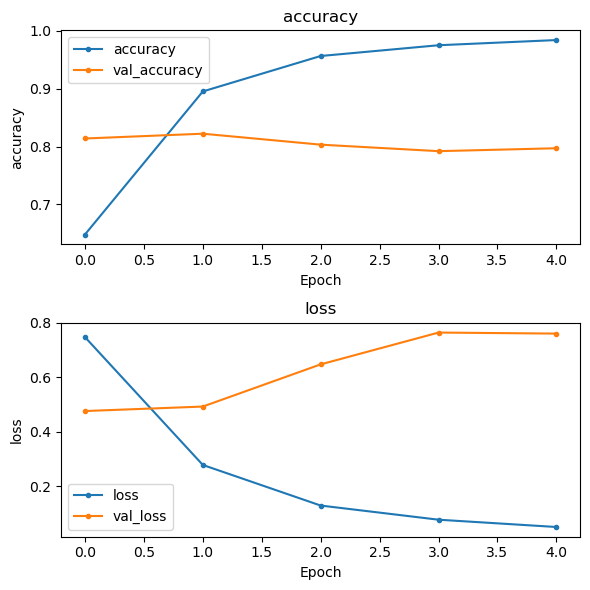


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       559
           1       0.82      0.84      0.83       560
           2       0.83      0.84      0.84       572

    accuracy                           0.82      1691
   macro avg       0.82      0.82      0.82      1691
weighted avg       0.82      0.82      0.82      1691



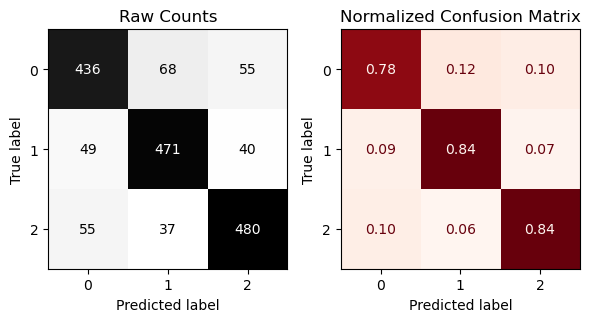


- Evaluating Test Data:
53/53 [==============================] - 1s 22ms/step - loss: 0.7106 - accuracy: 0.8202
{'loss': 0.7106183767318726, 'accuracy': 0.8202247023582458}


In [22]:
# Build model
model = build_hybrid_model_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(train_ds, epochs = EPOCHS,
                   validation_data = val_ds, callbacks = get_callbacks())
results = cf.evaluate_classification_network(model, X_test = test_ds, history = history);

In [23]:
def build_gru_model_bi_pool(text_vectorization_layer):

    gru_model_bi_pool = Sequential([text_vectorization_layer, 
                                   layers.Embedding(input_dim = v_size,
                                                   output_dim = 100,
                                                   input_length = 400)])

    # Add bidirectional component to GRU layer
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))

    # Add a pooling layer 
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())

    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation = 'softmax'))

    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy',
                             metrics = ['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 400, 100)          2097600   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         176640    
 l)                                                              
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                      

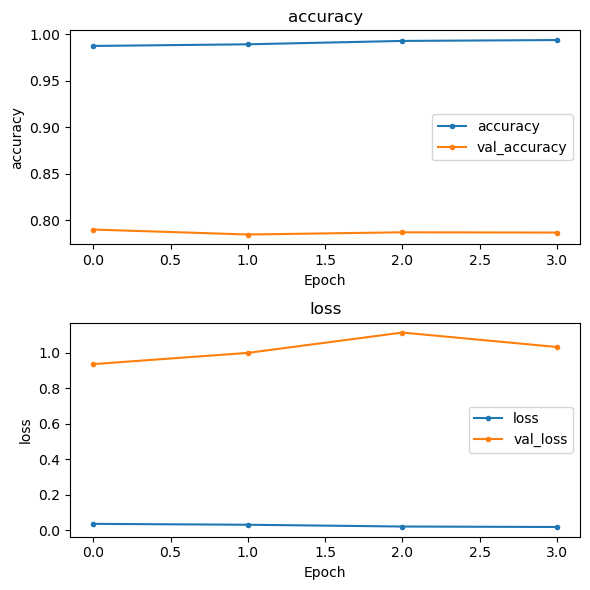


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3906
           1       1.00      0.99      1.00      3952
           2       1.00      0.99      1.00      3975

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



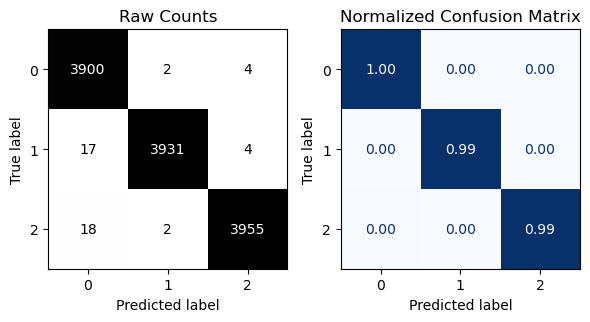


- Evaluating Training Data:
370/370 [==============================] - 8s 21ms/step - loss: 0.0132 - accuracy: 0.9960
{'loss': 0.013172334991395473, 'accuracy': 0.9960280656814575}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       559
           1       0.83      0.79      0.81       560
           2       0.81      0.81      0.81       572

    accuracy                           0.80      1691
   macro avg       0.80      0.80      0.80      1691
weighted avg       0.80      0.80      0.80      1691



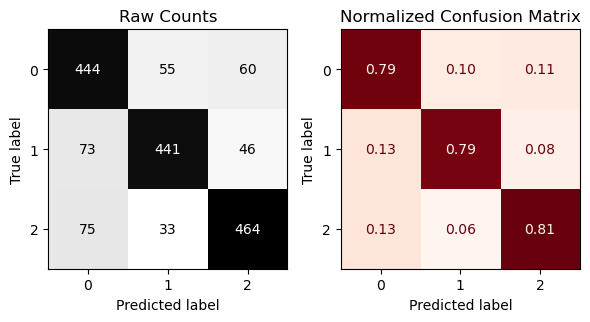


- Evaluating Test Data:
53/53 [==============================] - 1s 22ms/step - loss: 0.9626 - accuracy: 0.7978
{'loss': 0.9625815749168396, 'accuracy': 0.7977527976036072}


In [24]:
# Build the model
model1 = build_gru_model_bi_pool(sequence_vectorizer)

# Fit the model
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds,
                   callbacks = get_callbacks())

# Evaluate the model
results = cf.evaluate_classification_network(model, X_train = train_ds, X_test = test_ds,
                                            history = history);

# Pre - Trained

import zipfile
import os

# Specify the path to your zip file
zip_file_path = 'Data/glove.6B.zip'

# Specify the directory where you want to extract the contents
extracted_folder_path = 'Data/'

# Create the extraction folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Display a message indicating successful extraction
print(f"Contents of {zip_file_path} have been extracted to {extracted_folder_path}")


from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format('Data/glove.6B.100d.txt', binary = False,
                                               no_header=True)

In [33]:
len(glove_model)

400000

In [34]:
vocab_size = len(sequence_vectorizer.get_vocabulary())
embedding_dim = 100

In [35]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [37]:
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        pass

In [38]:
embedding_matrix[3]

array([-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001,
        0.48784   , -0.58825999, -0.17982   , -1.35810006,  0.42541   ,
        0.15377   ,  0.24214999,  0.13474   ,  0.41192999,  0.67043   ,
       -0.56418002,  0.42985001, -0.012183  , -0.11677   ,  0.31781   ,
        0.054177  , -0.054273  ,  0.35516   , -0.30241001,  0.31434   ,
       -0.33846   ,  0.71714997, -0.26855001, -0.15837   , -0.47466999,
        0.051581  , -0.33252001,  0.15003   , -0.12989999, -0.54617   ,
       -0.37843001,  0.64261001,  0.82187003, -0.080006  ,  0.078479  ,
       -0.96976   , -0.57740998,  0.56490999, -0.39873001, -0.057099  ,
        0.19743   ,  0.065706  , -0.48091999, -0.20125   , -0.40834001,
        0.39456001, -0.02642   , -0.11838   ,  1.01199996, -0.53171003,
       -2.74740005, -0.042981  , -0.74848998,  1.75740004,  0.59085   ,
        0.04885   ,  0.78267002,  0.38497001,  0.42096999,  0.67882001,
        0.10337   ,  0.63279998, -0.026595  ,  0.58647001, -0.44

In [39]:
from tensorflow.keras.layers import Embedding
# Create the embedding layer using the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)
glove_embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                 embeddings_initializer=initializer, trainable=False,
                                 input_length=400)

In [43]:
def build_model_glove(text_vectorization_layer, glove_embedding_layer):
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()

    model = Sequential([text_vectorization_layer, glove_embedding_layer])

    #BidirectionalGRU layer
    model.add(layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True,
                                                     dropout = .2)))
    # Pooling layer
    model.add(layers.GlobalMaxPooling1D())

    # Output layer
    model.add(layers.Dense(len(classes), activation='softmax'))

    # Define the optimizer
    optimizer = optimizers.legacy.Adam(learning_rate = .01)

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 400, 100)          2097600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 400, 256)         176640    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                      

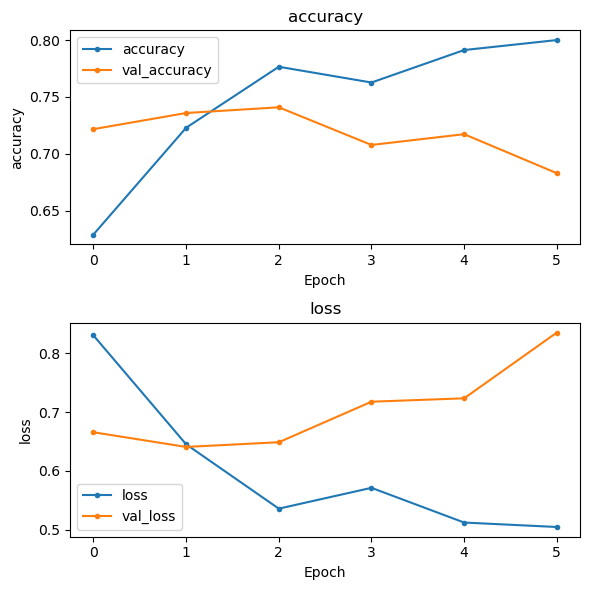


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3906
           1       0.79      0.74      0.76      3952
           2       0.73      0.79      0.76      3975

    accuracy                           0.75     11833
   macro avg       0.75      0.75      0.75     11833
weighted avg       0.75      0.75      0.75     11833



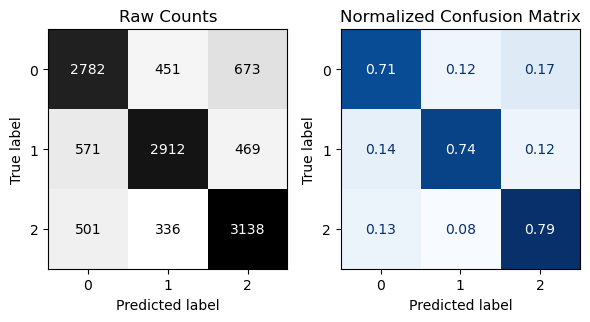


- Evaluating Training Data:
370/370 [==============================] - 13s 35ms/step - loss: 0.6302 - accuracy: 0.7464
{'loss': 0.6302444338798523, 'accuracy': 0.746387243270874}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       559
           1       0.72      0.66      0.69       560
           2       0.68      0.74      0.71       572

    accuracy                           0.69      1691
   macro avg       0.69      0.69      0.69      1691
weighted avg       0.69      0.69      0.69      1691



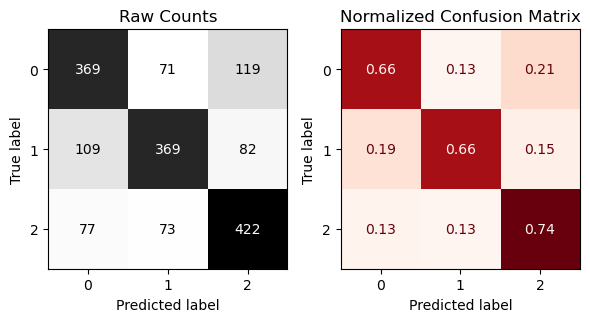


- Evaluating Test Data:
53/53 [==============================] - 2s 37ms/step - loss: 0.8452 - accuracy: 0.6860
{'loss': 0.845240592956543, 'accuracy': 0.6859846115112305}


In [45]:
baseline_model = build_model_glove(sequence_vectorizer,glove_embedding_layer)
EPOCHS = 100

# Fit the model
history = baseline_model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds,
                            callbacks=get_callbacks())

# Evauluate the model
results = cf.evaluate_classification_network(baseline_model, X_train = train_ds, 
                                         X_test=test_ds, history=history);

- Best model was hybrid model with GRU and LSTM
    - .82 Accuracy
    - Other model probably too simple, only had one layer